In [1]:
import timeit

import numpy as np
import matplotlib.pyplot as plt

from scripts.queso_model import model_data, model_vars, objective_func, balance, alloc_df

# Enfriamiento Simulado

## Parámetros

In [2]:
# ¿Cómo se obtienen estas variables desde el sistema de información?

# Escenario 1
folder = './data/test1/' # Carpeta con los datos
info_acopios = 'nuevo_info_acopios.xlsx' # Datos de centros de acopio 
costo_transporte = 'costoTransporteCAi.xlsx' # Matriz de costos de transporte entre CAs 
tiempo_transporte = 'tiempoTransporteCAi.xlsx' # Matriz de tiempos de transporte entre CAs
demanda = 60 # Demanda del cliente
ctiempo = 100 # Costo por unidad de tiempo

# Escenario 2
# folder = './data/test2/'
# info_acopios = 'centros_acopio.xlsx'
# costo_transporte = 'costo_transporte.xlsx'
# tiempo_transporte = 'tiempos_transporte.xlsx'
# demanda = 4000
# ctiempo = 100

# Escenario 3
# folder = './data/test3/'
# info_acopios = 'info_acopios_escenario3.xlsx'
# costo_transporte = 'costo_transporte_escenario3.xlsx'
# tiempo_transporte = 'tiempos_transporte_escenario3.xlsx'
# demanda = 60
# ctiempo = 1000

# Temperatura inicial
max_anneal = 1.e7
# Temperatura final de enfriamiento (terminación)
min_anneal = 1.e-2
# Energía mínima (terminación)
energy = 1.5e5
# Ratio de enfriamiento
# r_anneal = 0.9871
r_anneal = 0.9921

In [3]:
archivos = {
    'info_acopios': info_acopios,
    'costo_transporte' : costo_transporte,
    'tiempo_transporte' : tiempo_transporte,
}

data = model_data(archivos, demanda, ctiempo, folder=folder)

demanda = data['demanda']
ctiempo = data['ctiempo']
# t_max = data['t_max']
params_df = data['params_df']

N, seed, capacidades = model_vars(params_df)

## Generación

Solución inicial $s_0$

In [4]:
# Generador del estado inicial
def gen_s0(n_vars):
    # Se indexan los centros de acopio
    gen_vector = np.zeros(n_vars+1, dtype=float)

    # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
    indices = np.arange(n_vars)
    np.random.shuffle(indices)

    while np.sum(gen_vector) < demanda and indices.size > 0:
        idx = indices[0]
        gen_vector[idx] += capacidades[idx]
        indices = np.delete(indices, 0)

        if np.sum(gen_vector) > demanda:
            gen_vector[idx] = gen_vector[idx] - (np.sum(gen_vector) - demanda)
            break

    gen_vector[n_vars] = np.random.randint(capacidades[n_vars] + 1)

    return gen_vector

Soluciones consecutivas $s_n$

In [5]:
def gen_s(sol):
    # Se indexan y reorganizan las asignaciones del vector
    indices = np.arange(N*2+1)
    np.random.shuffle(indices)

    idx = indices[0]

    while indices.size > 0:
        # Si es el índice del centro de acopio principal (N*2)
        if idx == N*2:
            cap = sol[idx].astype(int)
            # Se escoge cualquier centro de acopio distinto al actual
            cap = np.delete(np.arange(capacidades[N*2]+1), cap)
            sol[idx] = np.random.choice(cap)
            break

        # Si la cantidad máxima posible es cero...
        if sol[idx] == 0 == capacidades[idx]:
            # Probar con el siguiente índice
            indices = np.delete(indices, 0)
            idx = indices[0]
            continue

        # Asignación de centros de acopio sin el centro principal
        s = np.delete(sol, N*2)

        if s[idx] == 0:
            # Se asigna la máxima cantidad posible del índice
            delta = capacidades[idx]
            s[idx] = capacidades[idx]
            diff = True
        else:
            # Se asigna cero a la cantidad del índice
            delta = s[idx]
            s[idx] = 0
            diff = False

        balance(s, capacidades, delta, diff)
        sol = np.append(s, sol[N*2])
        break

    return sol

Pseudocódigo del método de enfriamiento simulado implementado:

$$
\textit{Sea } s = s_0 \\ 
\textit{Mientras } t > t_{min}, e > e_{th}: \\
\qquad \text{Generar una nueva solución aleatoria, } s_{new} \leftarrow genS(s) \\ 
\qquad \textit{Si } f(s) > f(s_{new}): \\
\qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\qquad \textit{Sino:} \\
\qquad \qquad \textit{Si } P(f(s), f(s_{new}), t) \geq rand(0, 1): \\ 
\qquad \qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\text{Salida: } s_{final}
$$

In [6]:
historial_delta = []
historial_t = []
historial_e = []

def anneal(t, t_min, e_th, alpha):
    # Función objetivo
    f = objective_func
    # Estado inicial (s0)
    s = gen_s0(N*2)
    # función a optimizar (a.k.a energía, fitness)
    e = f(s, N, data)
    # Contador de iteraciones o pasos
    k = 0
    
    historial_f = []

    while t > t_min and e > e_th:
        s_new = gen_s(s)
        e_new = f(s_new, N, data)
        
        ' !!!!!!!! '
        historial_f.append(e)

        delta = e_new - e
        historial_delta.append(delta)

        if delta < 0:
            s = s_new
            e = e_new
        else:
            p = np.exp(-delta / t)
            historial_e.append(p)
            r = np.random.rand()

            if r < p:
                s = s_new
                e = e_new

        t *= alpha
        historial_t.append(t)
        k += 1

    return s, k, historial_f


## Aplicación

In [7]:
def sa(t_max, t_min, e_th, alpha, key=1):
    np.random.seed(key)
    x, count, historial_f = anneal(t_max, t_min, e_th, alpha)
    print(f'Count: ', count)
    return x, historial_f

t_start_sa = timeit.default_timer()
annealing, historial = sa(max_anneal, min_anneal, energy, r_anneal)
t_end_sa = timeit.default_timer()

t_delta_sa = t_end_sa - t_start_sa

Count:  2613


In [8]:
# print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(annealing[N*2])]}')
print(f'Precio: {objective_func(annealing, N, data)}')
print(f'Tiempo: {round(t_delta_sa * 1000)}ms, ({t_delta_sa}s)')
# print(np.min(historial))
# print(annealing)

Precio: 435531.0
Tiempo: 1487ms, (1.4871898000128567s)


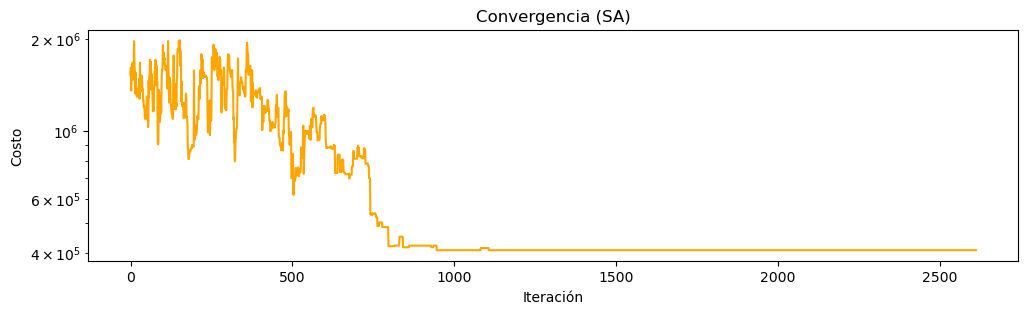

In [9]:
plt.figure(figsize=(12,3))
plt.title('Convergencia (SA)')
plt.xlabel('Iteración')
plt.ylabel('Costo')
plt.plot(historial, '-', c='orange')
plt.yscale('log')
plt.show()

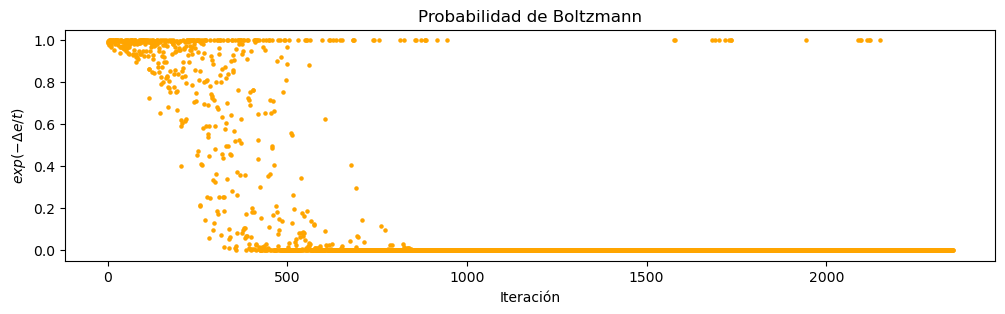

In [10]:
plt.figure(figsize=(12,3))
plt.title('Probabilidad de Boltzmann')
plt.xlabel('Iteración')
plt.ylabel('$exp(-Δe/t)$')
plt.scatter(np.arange(len(historial_e)), historial_e, 5, 'orange')
plt.show()

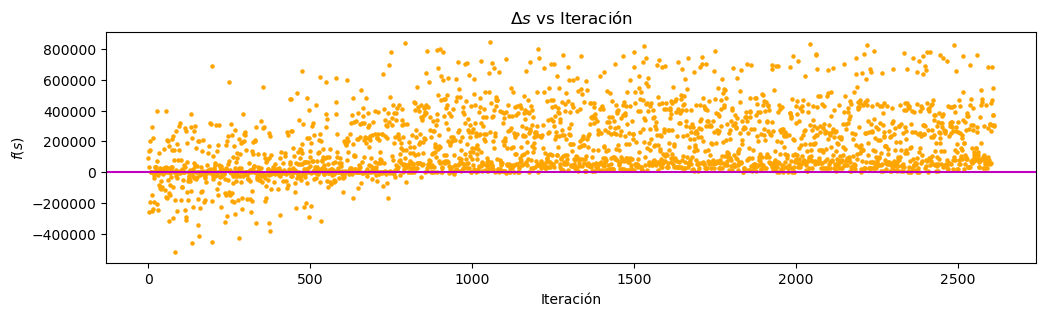

In [11]:
plt.figure(figsize=(12,3))
plt.title('$Δs$ vs Iteración')
plt.xlabel('Iteración')
plt.ylabel('$f(s)$')
plt.scatter(np.arange(len(historial_delta)), historial_delta, 5, c='orange')
plt.axhline(y=0, c='m', linestyle='-')
plt.show()

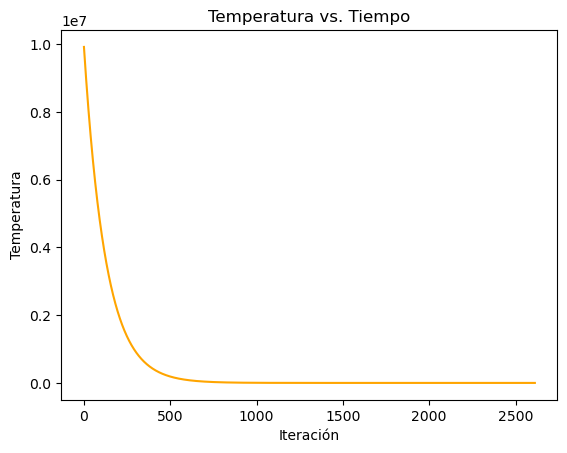

In [12]:
plt.plot(historial_t, c='orange')
plt.title('Temperatura vs. Tiempo')
plt.xlabel('Iteración')
plt.ylabel('Temperatura')
plt.show()

In [13]:
asignaciones = alloc_df(annealing, params_df, N, capacidades)
asignaciones

,CAcopio,C.Stock,Stock,C.Potencial,Potencial
0,CA1,10.0,10.000,0.500,0.500
1,CA2,12.0,10.375,0.625,0.625
2,CA3,4.0,0.000,14.000,0.000
3,CA4,8.0,8.000,13.000,13.000
4,CA5,18.0,0.000,15.000,0.000
5,CA6,6.0,0.000,14.000,0.000
6,CA7,12.0,2.000,13.000,1.500
7,CA8,2.0,2.000,12.500,12.000
8,CA9,30.0,0.000,15.000,0.000
9,CA10,15.0,0.000,18.000,0.000


## Resultados

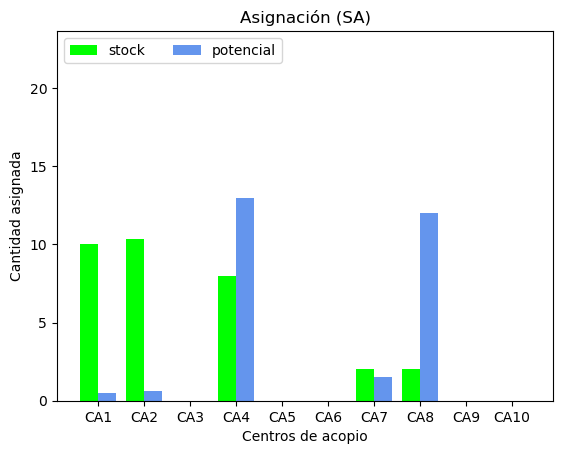

In [14]:
even = np.arange(0, N*2-1, 2)
odd = np.arange(1, N*2, 2)

cap_stock = np.take(capacidades, even)
cap_potencial = np.take(capacidades, odd)

ca_stock = np.take(annealing, even)
ca_potencial = np.take(annealing, odd)
    
labels = params_df['Id_CA']
x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

_, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(capacidades), np.max(annealing)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='lime')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='cornflowerblue')

plt.xticks(x, labels)
plt.title('Asignación (SA)')
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

In [15]:
ca_stock_norm = ca_stock / cap_stock
ca_potencial_norm = ca_potencial / cap_potencial

ca_norm = ca_stock_norm.tolist()
for i,v in enumerate(ca_potencial_norm):
    ca_norm.insert(2 * i + 1, v)
ca_norm.append(0)
ca_norm = np.round(ca_norm, 3)
ca_norm = ca_norm * 100

ca_norm_df = alloc_df(ca_norm, params_df, N, capacidades, '% Stock', '% Potencial')
ca_norm_df

,CAcopio,C.Stock,% Stock,C.Potencial,% Potencial
0,CA1,10.0,100.0,0.500,100.0
1,CA2,12.0,86.5,0.625,100.0
2,CA3,4.0,0.0,14.000,0.0
3,CA4,8.0,100.0,13.000,100.0
4,CA5,18.0,0.0,15.000,0.0
5,CA6,6.0,0.0,14.000,0.0
6,CA7,12.0,16.7,13.000,11.5
7,CA8,2.0,100.0,12.500,96.0
8,CA9,30.0,0.0,15.000,0.0
9,CA10,15.0,0.0,18.000,0.0


# todo

Comenzar a buscar parámetros óptimos y documentar los resultados (La solución es óptima?) 

Hacer varias ejecuciones y medir estadísticos sobre los resultados obtenidos (varianza)

In [16]:
# # n ejecuciones
# evals = []
# def sa_test(n):
#     hist = []
#     hist_t = []
#     
#     for i in range(n):
#         
#         t_i = timeit.default_timer()
#         opt, graph = sa(max_anneal, min_anneal, energy, r_anneal)
#         t_f = timeit.default_timer()
# 
#         evals.append(graph)
#         
#         t_delta = t_f - t_i
#         hist.append(objective_func(opt, N, data))
#         hist_t.append(t_delta)
#         
#     return hist, hist_t, n
# 
# history, hist_time, times = sa_test(5)
# print(history, '\n', hist_time, '\n', times)

In [17]:
# _, ax = plt.subplots(5, 1, figsize=(12, 8))
# # Convergencia para N iteraciones
# 
# for m in range(5):
#     ax[m].plot(evals[m])
# plt.show()

In [18]:
# plt.bar(np.arange(times), hist_time)
# plt.ylim([np.min(hist_time)*0.975, np.max(hist_time)*1.025])
# plt.title('Tiempo por optimización')
# plt.show()